# Train G&D Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.autograd as autograd
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# Class Model

In [3]:
class MnistCNN(nn.Module):

    def __init__(self,input_dim,num_classes):
        super(MnistCNN, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(1, 32, 3,1)
        self.conv2 = nn.Conv2d(32, 64, 3 ,1)
        self.fc3 = nn.Linear(64, 64)
        #self.fc4 = nn.Linear(128, 10)
        self.fc4 = nn.Linear(input_dim*64,num_classes)
        #fc_layers.append(nn.Linear(input_dim*128,num_classes))
        
    def forward(self, x):    
        h = F.relu(self.conv1(x))        
        h = F.relu(self.conv2(h))        
        h = F.dropout2d(F.max_pool2d(h, 5), p=0.25)
        h = F.dropout2d(self.fc3(h.view(h.size(0), -1)), p=0.5)
        h = self.fc4(h)
        return F.log_softmax(h,dim=1)

class CifarCNN(nn.Module):

    def __init__(self , num_classes):
        super(CifarCNN, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, num_classes)

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)))        
        h = F.relu(self.bn2(self.conv2(h)))        
        h = F.max_pool2d(h, 2)        
        h = F.relu(self.bn3(self.conv3(h)))   
        h = F.max_pool2d(h, 2)        
        h = F.relu(self.bn4(self.conv4(h)))        
        h = F.max_pool2d(h, 2)        
        h = F.relu(self.fc5(h.view(h.size(0), -1)))
        h = F.relu(self.fc6(h))
        h = self.fc7(h)
        return F.log_softmax(h,dim=1)    

class Generator(nn.Module):

    def __init__(self, in_ch):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 64, 3, stride=2 , padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2 , padding=1) 
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 3, stride=2 , padding=1) 
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, in_ch, 3, stride=2 , padding=1) 

    def forward(self, x):
        h = F.leaky_relu(self.bn1(self.conv1(x)))
        h = F.leaky_relu(self.bn2(self.conv2(h)))
        h = F.leaky_relu(self.bn3(self.deconv3(h)))        
        h = torch.tanh(self.deconv4(h))        
        return h

class Discriminator(nn.Module):

    def __init__(self, in_ch):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, 64, 1, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 1, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 1, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        if in_ch == 1:
            self.fc4 = nn.Linear(1024, 1)            
        else:
            self.fc4 = nn.Linear(2304, 1)

    def forward(self, x):
        h = F.leaky_relu(self.conv1(x))
        h = F.leaky_relu(self.bn2(self.conv2(h)))
        h = F.leaky_relu(self.bn3(self.conv3(h)))        
        h = torch.sigmoid(self.fc4(h.view(h.size(0), -1)))
        return h

In [4]:
def accuracy(y, t):
    pred = y.data.max(1, keepdim=True)[1]
    acc = pred.eq(t.data.view_as(pred)).cpu().sum()
    return acc

In [5]:
def fgsm(model, x, t, loss_func, eps, min=0, max=1):
    if not isinstance(x, Variable):
        x, t = Variable(x.cuda(), requires_grad=True), Variable(t.cuda())
    x.requires_grad = True
    y = model(x)
    loss = loss_func(y, t)
    model.zero_grad()
    loss.backward(retain_graph=True)

    return Variable(torch.clamp(x.data + eps * torch.sign(x.grad.data), min=min, max=max))

In [6]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [7]:
import matplotlib.pyplot as plt
def show_images(e, x, x_adv, x_fake, save_dir):
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    for i in range(5):
        axes[0, i].axis("off"), axes[1, i].axis("off"), axes[2, i].axis("off")
        #axes[0, i].imshow(x[i].cpu().numpy().transpose((1, 2, 0)))
        axes[0, i].imshow(x[i, 0].cpu().numpy(), cmap="gray")
        axes[0, i].set_title("Normal")

        #axes[1, i].imshow(x_adv[i].cpu().numpy().transpose((1, 2, 0)))
        axes[1, i].imshow(x_adv[i, 0].cpu().numpy(), cmap="gray")
        axes[1, i].set_title("Adv")

        #axes[2, i].imshow(x_fake[i].cpu().numpy().transpose((1, 2, 0)))
        axes[2, i].imshow(x_fake[i, 0].cpu().numpy(), cmap="gray")
        axes[2, i].set_title("Proposed_GAN")
    plt.axis("off")
    plt.savefig(os.path.join(save_dir, "result_{}.png".format(e)))

In [8]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [9]:
#data ="minst"
epochs = 10
lr= 0.0002
batch_size = 128
eps = 0.15
input_dim = 1
num_class = 11
checkpoint ="/content/drive/MyDrive/IDS(attacks&Defense)/checkpoint/CNN_Mnist"

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [10]:
target_model = MnistCNN(input_dim=input_dim, num_classes=num_class)
print (target_model)

#target_model = CifarCNN(num_classes=num_class)
#print (target_model)

target_model.load_state_dict(torch.load('/content/drive/MyDrive/IDS(attacks&Defense)/models/MnistCNN.tar')["state_dict"])
target_model.eval()

check_path = checkpoint
os.makedirs(check_path, exist_ok=True)

fgsm = torch.load('/content/drive/MyDrive/IDS(attacks&Defense)/models/fgsm.tar')
train_data = fgsm['normal_data_x']
train_label = fgsm['normal_data_t']
adv_fgsm = fgsm['adv']

x_tmp = train_data[500:505]
x_adv_tmp = adv_fgsm[500:505]

train_data = TensorDataset(train_data,train_label,adv_fgsm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

MnistCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=11, bias=True)
)


In [11]:
in_ch = 1 # if data == "mnist" else 3

auxiliary_loss = torch.nn.CrossEntropyLoss()
loss_mse = nn.MSELoss()

G = Generator(in_ch).to(device)
D = Discriminator(in_ch).to(device)
print (G)
print (D)

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
cudnn.benchmark = True

Generator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(1, 1), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): 

# Train

Epoch	Gen_Loss	Dis_Loss


  0%|          | 0/8847 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
                                                   

0	-0.114110	-0.232262


1	-0.400701	-0.129880


2	-0.426481	-0.140810


3	-0.691791	-0.060987


4	-0.740239	-0.056947


5	-0.562987	-0.060655


6	0.101951	-0.109693


7	-0.034363	-0.329781


8	-0.433175	-0.175218


9	-0.462576	-0.070152


Generator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

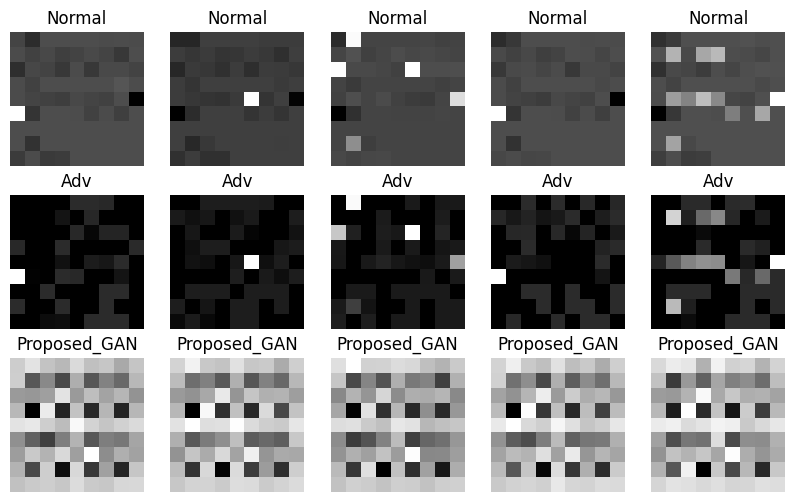

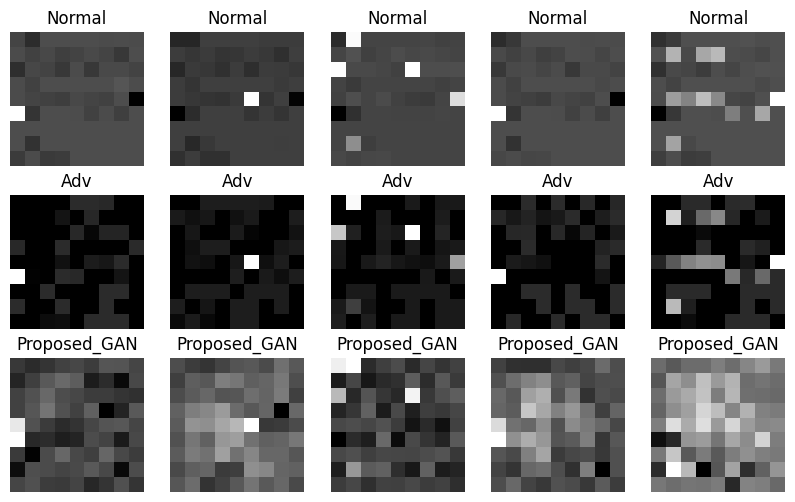

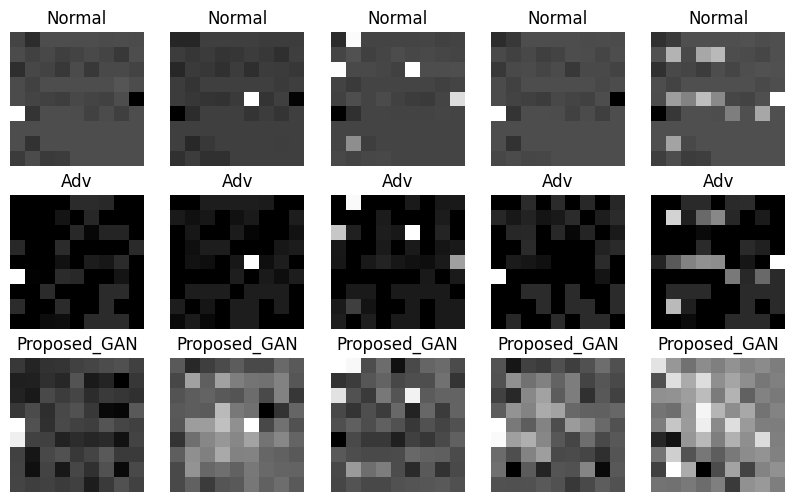

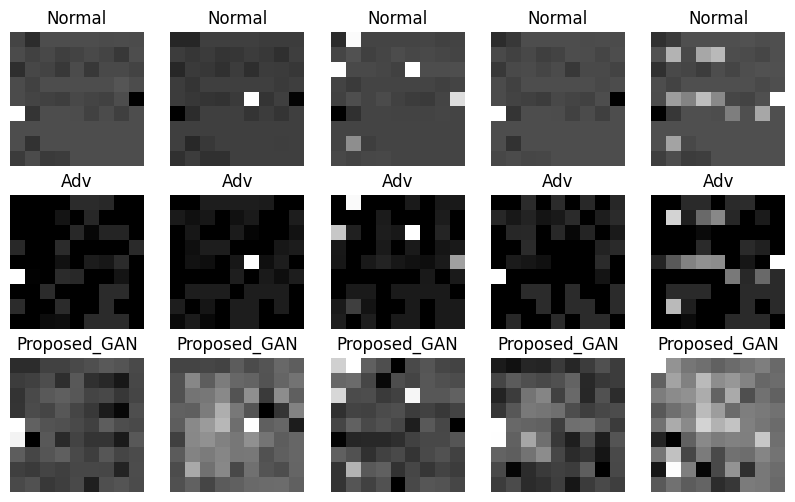

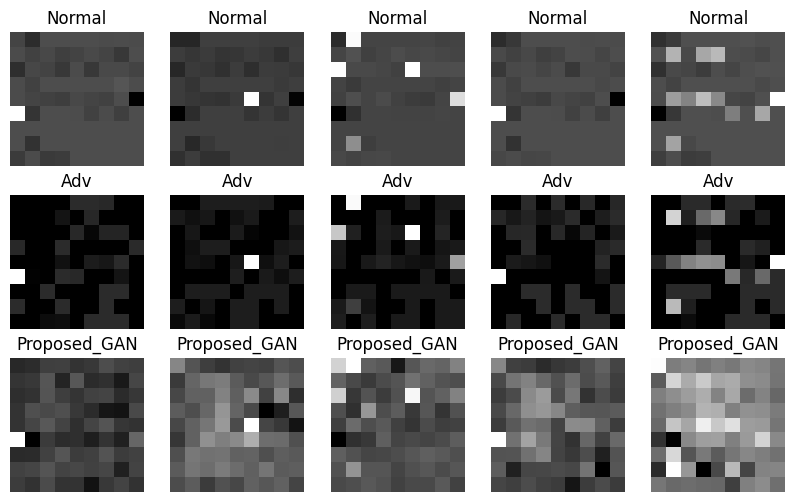

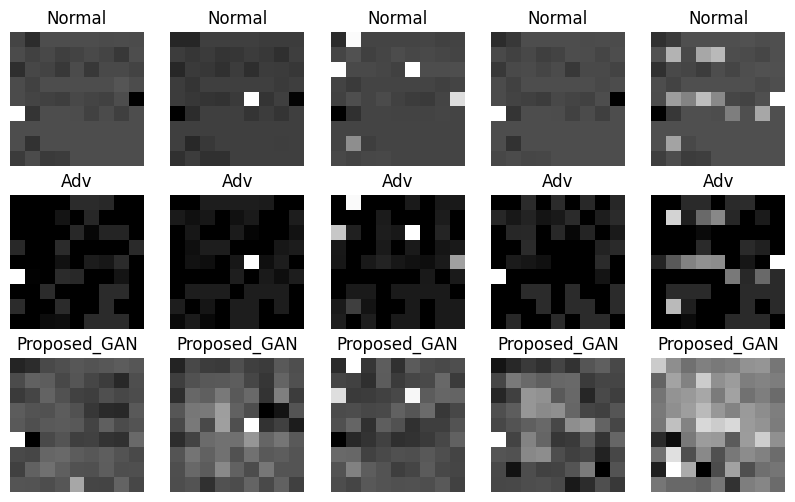

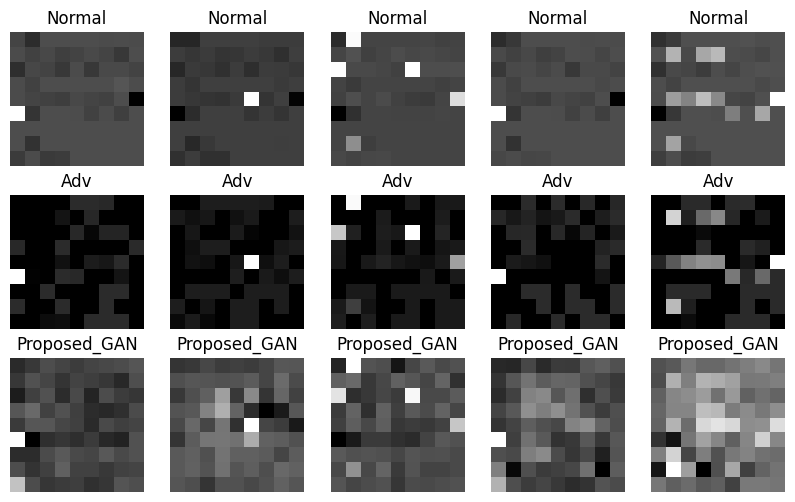

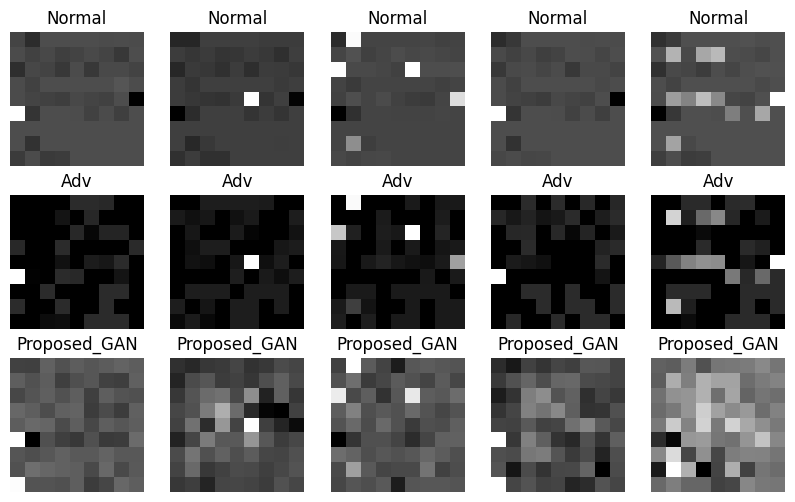

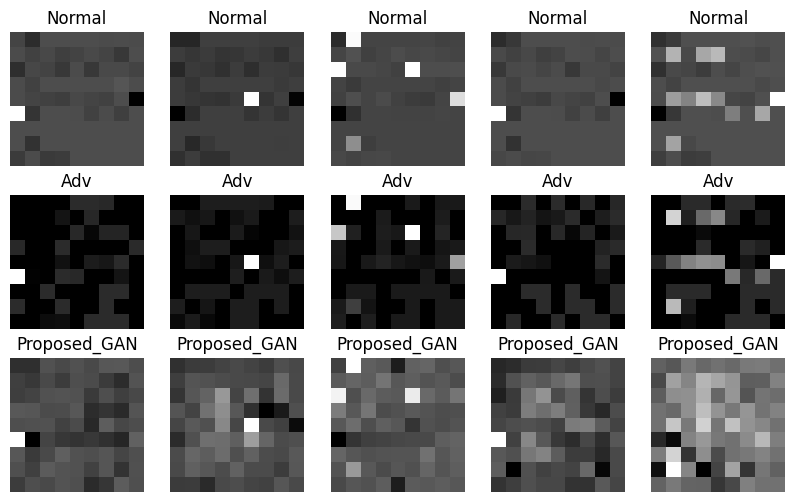

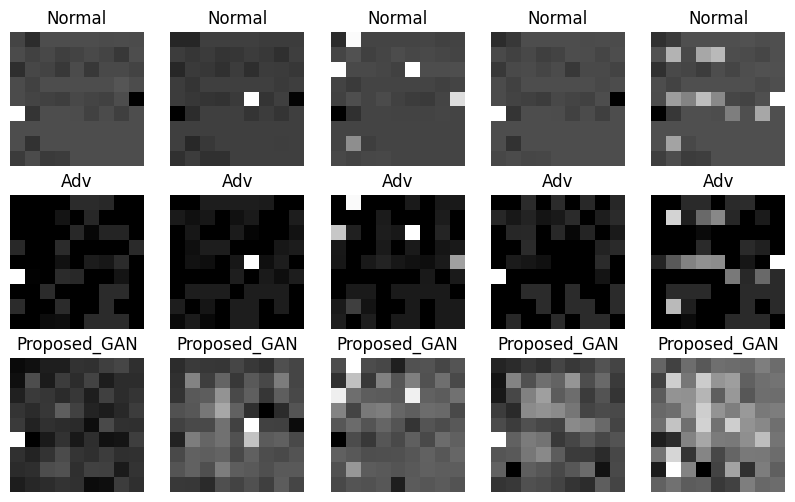

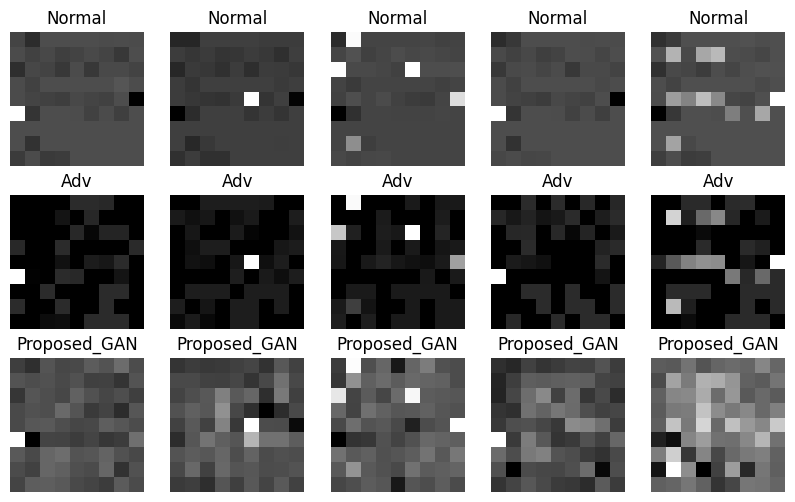

In [12]:
writer = SummaryWriter('./log/Mnist')
print_str = "\t".join(["{}"] + ["{:.6f}"] * 2)
print("\t".join(["{:}"] * 3).format("Epoch", "Gen_Loss", "Dis_Loss"))
for e in range(epochs):
    G.eval()
    x_fake = G(Variable(x_adv_tmp.to(device))).data
    show_images(e, x_tmp, x_adv_tmp, x_fake, check_path)
    G.train()
    gen_loss, dis_loss, n = 0, 0, 0
    for x, x_label, x_adv in tqdm(train_loader, total=len(train_loader), leave=False):
        x, x_real_label, x_adv = Variable(x.to(device)),Variable(x_label.to(device)),Variable(x_adv.to(device))
        x_real_label = Variable(x_real_label.type(LongTensor))
        
        # Train D     
        y_real = D(x).squeeze()
        x_fake = G(x_adv)
        y_fake = D(x_fake).squeeze()
        gradient_penalty = compute_gradient_penalty(D, x.data, x_fake.data)
        lambda_gp = 10
        loss_D = -torch.mean(y_real) + torch.mean(y_fake) + lambda_gp * gradient_penalty
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train G
        for _ in range(1):
            x_fake = G(x_adv)
            y_fake = D(x_fake).squeeze()
            # if e >100:
            loss_G = -torch.mean(y_fake) + 0.5*auxiliary_loss(target_model(x_fake),x_real_label) + 0.5*loss_mse(x_fake, x)
            # else:
                # loss_G = -torch.mean(y_fake)
            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        gen_loss += loss_D.item() * x.size(0)
        dis_loss += loss_G.item() * x.size(0)
        n += x.size(0)
    writer.add_scalar('dis_loss', dis_loss, e)
    writer.add_scalar('gen_loss', gen_loss, e)
    print(print_str.format(e, gen_loss / n, dis_loss / n) , flush=True)
    torch.save({"generator": G.state_dict(), "discriminator": D.state_dict()}, 
                             os.path.join(check_path, "{}.tar".format(e + 1)))

G.eval()
x_fake = G(Variable(x_adv_tmp.to(device))).data
show_images(epochs, x_tmp, x_adv_tmp, x_fake, check_path)
G.train()